In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/imet-2019-fgvc6/train.csv')
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')
test = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 0.001
WARMUP_LEARNING_RATE = 0.001
HEIGHT = 156
WIDTH = 156
CANAL = 3
N_CLASSES = labels.shape[0]
ES_PATIENCE = 4
RLROP_PATIENCE = 2
DECAY_DROP = 0.5
DECAY_EPOCHS = 10

In [4]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score


def custom_f2(y_true, y_pred):
    beta = 2

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta**2)*p*r / (p*beta**2 + r + 1e-15)

    return f2

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = DECAY_DROP
    epochs_drop = DECAY_EPOCHS
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25,
                                 rotation_range=90, 
                                 horizontal_flip=True,
                                 fill_mode='nearest')

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.
Found 7443 images.


### Model

In [6]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.Xception(weights=None, include_top=False,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [7]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5,0):
    model.layers[i].trainable = True

metrics = ["accuracy", "categorical_accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156, 156, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 77, 77, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 77, 77, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Act

#### Train top layers

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
 - 1495s - loss: 0.0255 - acc: 0.9964 - categorical_accuracy: 0.1120 - val_loss: 0.0228 - val_acc: 0.9970 - val_categorical_accuracy: 0.1241
Epoch 2/2
 - 1546s - loss: 0.0160 - acc: 0.9971 - categorical_accuracy: 0.1252 - val_loss: 0.0200 - val_acc: 0.9967 - val_categorical_accuracy: 0.1388


#### Fine-tune the complete model

In [9]:
for layer in model.layers:
    layer.trainable = True

# lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callbacks = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156, 156, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 77, 77, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 77, 77, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 77, 77, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [10]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              verbose=2)

Epoch 1/30
 - 1688s - loss: 0.0113 - acc: 0.9973 - val_loss: 0.0105 - val_acc: 0.9974
Epoch 2/30
 - 1660s - loss: 0.0102 - acc: 0.9974 - val_loss: 0.0180 - val_acc: 0.9972
Epoch 3/30
 - 1683s - loss: 0.0098 - acc: 0.9975 - val_loss: 0.0101 - val_acc: 0.9975
Epoch 4/30
 - 1695s - loss: 0.0094 - acc: 0.9975 - val_loss: 0.0166 - val_acc: 0.9972
Epoch 5/30
 - 1690s - loss: 0.0090 - acc: 0.9976 - val_loss: 0.0112 - val_acc: 0.9975

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
 - 1697s - loss: 0.0082 - acc: 0.9977 - val_loss: 0.0095 - val_acc: 0.9977
Epoch 7/30
 - 1696s - loss: 0.0079 - acc: 0.9978 - val_loss: 0.0088 - val_acc: 0.9977
Epoch 8/30
 - 1653s - loss: 0.0076 - acc: 0.9978 - val_loss: 0.0088 - val_acc: 0.9977
Epoch 9/30
 - 1687s - loss: 0.0073 - acc: 0.9979 - val_loss: 0.0088 - val_acc: 0.9977

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/30
 - 1684s - loss: 0.0068 - acc: 0.9980 - val_loss: 0.

### Complete model graph loss

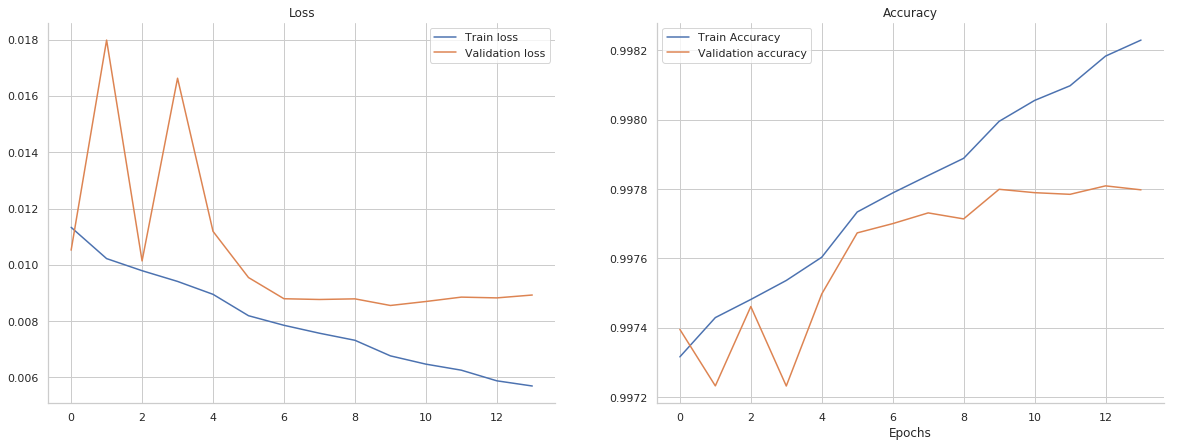

In [11]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(20,7))

ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [12]:
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
print(lastFullValPred.shape, lastFullValLabels.shape)

(27309, 1103) (27309, 1103)


thr=0.100 F2=0.538


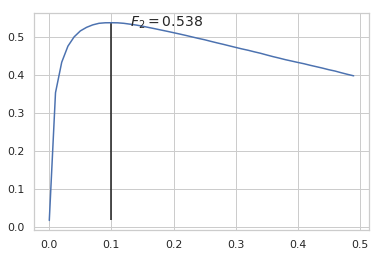

In [13]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in thrs:
        score.append(custom_f2(targs, (preds > thr).astype(int)))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

threshold, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

### Apply model to test set and output predictions

In [14]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [15]:
predictions = []
for pred_ar in preds:
    valid = []
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            valid.append(idx)
    if len(valid) == 0:
        valid.append(np.argmax(pred_ar))
    predictions.append(valid)

In [16]:
filenames = test_generator.filenames
label_map = {valid_generator.class_indices[k] : k for k in valid_generator.class_indices}

results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results['attribute_ids'] = results['attribute_ids'].apply(lambda x: list(map(label_map.get, x)))
results["attribute_ids"] = results["attribute_ids"].apply(lambda x: ' '.join(x))
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,1059 223 766
1,100fbe75ed8fd887,1039 231
2,101b627524a04f19,498 79
3,10234480c41284c6,1006 1046 13 147 480 483 51 738 776 813 975
4,1023b0e2636dcea8,1092 147 189 322 51 813 896 903 954
5,1039cd6cf85845c,1092 13 405 896
6,103a5b3f83fbe88,1092 13 194 671 744 813
7,10413aaae8d6a9a2,1092 147 813 896
8,10423822b93a65ab,1039 1059 188
9,1052bf702cb099f7,335 420 477 51 612 671 780
